# Peer-graded Assignment: Прогнозирование ряда со сложной сезонностью

In [2]:
from scipy import stats
import pandas as pd
import numpy as np
import calendar
from time import mktime
from sklearn.linear_model import LinearRegression as LR
import statsmodels.api as sm
import matplotlib.pyplot as plt
import os
import warnings
import itertools

%pylab inline

/home/feshch/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Populating the interactive namespace from numpy and matplotlib


## Загрузка данных за полгода с декабря 2015 по май 2016

In [3]:
def data_for_time_interval_and_region(first_year, first_month, last_year, last_month, data_dir = '../Data_aggr/', reg = 1231):
    data = pd.DataFrame()
    y = first_year
    m = first_month
    while [2016, 6]>=[y, m]:
        if [last_year, last_month]>=[y, m]:
            data_tmp = pd.read_csv(data_dir+str(y)+'-'+str(m)+'.csv', index_col='Unnamed: 0')
            data_tmp = data_tmp[data_tmp.region==reg]
            data = pd.concat([data, data_tmp])
        if m == 12:
            m = 1
            y += 1
        else:
            m += 1
    return data

In [4]:
data = data_for_time_interval_and_region(2015, 12, 2016, 5)

/home/feshch/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


## Беглый взгляд на данные

In [5]:
data.index = range(data.shape[0])
data.head()

pickup_hour  region  cnt
0  2015-12-01 00:00:00    1231  394
1  2015-12-01 01:00:00    1231  185
2  2015-12-01 02:00:00    1231  109
3  2015-12-01 03:00:00    1231  100
4  2015-12-01 04:00:00    1231   92

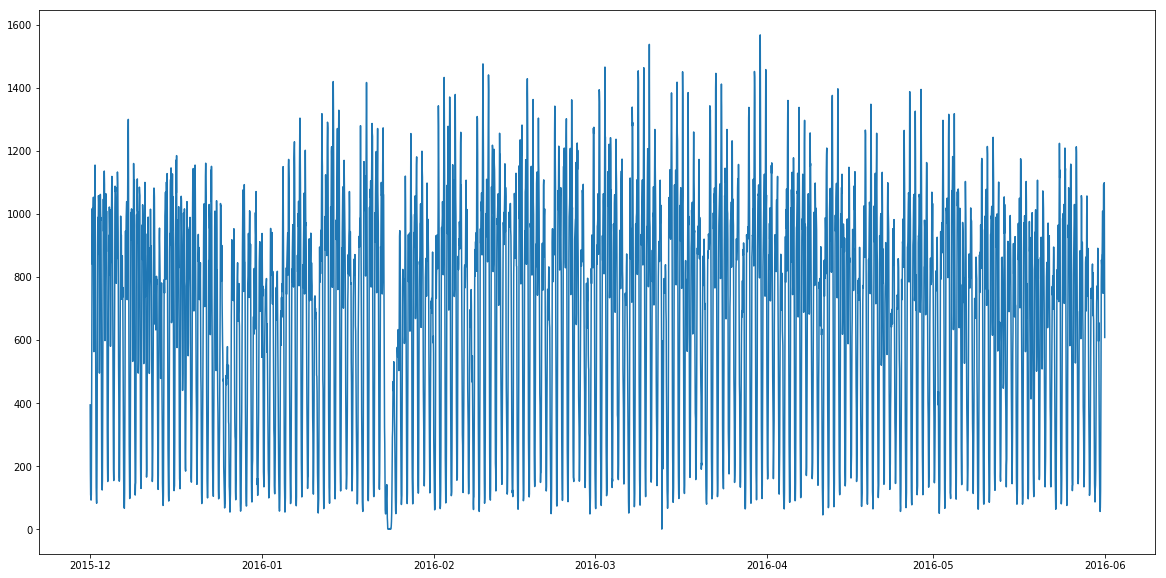

In [6]:
plt.figure(figsize=(20,10))
plt.plot(pd.to_datetime(data.pickup_hour), data.cnt)

### В конце января нулевое число поездок. В остальных регионах то же самое, скорее всего, отказ оборудования. Для учёта аномалии введём в Бокса-Кокса сдвиг

In [7]:
def inverse_shifted_boxcox(y, lmda, shift=10):
    return np.exp(y) - shift if lmda == 0 else (np.exp(np.log(lmda * y + 1) / lmda)) - shift

def shifted_boxcox(y, shift=10):
    return stats.boxcox(y + shift)   

In [8]:
data['boxcox'] = shifted_boxcox(data.cnt)[0]

## Будем моделировать суточную сезонность с помощью SARIMAX, предварительно сделав регрессионные признаки для учёта недельной сезонности

In [9]:
K=5
p = 2.*pi/168.
for i in range(1, K+1):
    phi = p*i
    data['week_s'+str(i)] = sin(data.index.values*phi)
    data['week_c'+str(i)] = cos(data.index.values*phi)
data.head()

pickup_hour  region  cnt      boxcox   week_s1   week_c1   week_s2  \
0  2015-12-01 00:00:00    1231  394  289.295703  0.000000  1.000000  0.000000   
1  2015-12-01 01:00:00    1231  185  146.036940  0.037391  0.999301  0.074730   
2  2015-12-01 02:00:00    1231  109   91.699744  0.074730  0.997204  0.149042   
3  2015-12-01 03:00:00    1231  100   85.133089  0.111964  0.993712  0.222521   
4  2015-12-01 04:00:00    1231   92   79.266053  0.149042  0.988831  0.294755   

    week_c2   week_s3   week_c3   week_s4   week_c4   week_s5   week_c5  
0  1.000000  0.000000  1.000000  0.000000  1.000000  0.000000  1.000000  
1  0.997204  0.111964  0.993712  0.149042  0.988831  0.185912  0.982566  
2  0.988831  0.222521  0.974928  0.294755  0.955573  0.365341  0.930874  
3  0.974928  0.330279  0.943883  0.433884  0.900969  0.532032  0.846724  
4  0.955573  0.433884  0.900969  0.563320  0.826239  0.680173  0.733052

## Предскажем линейной регрессией

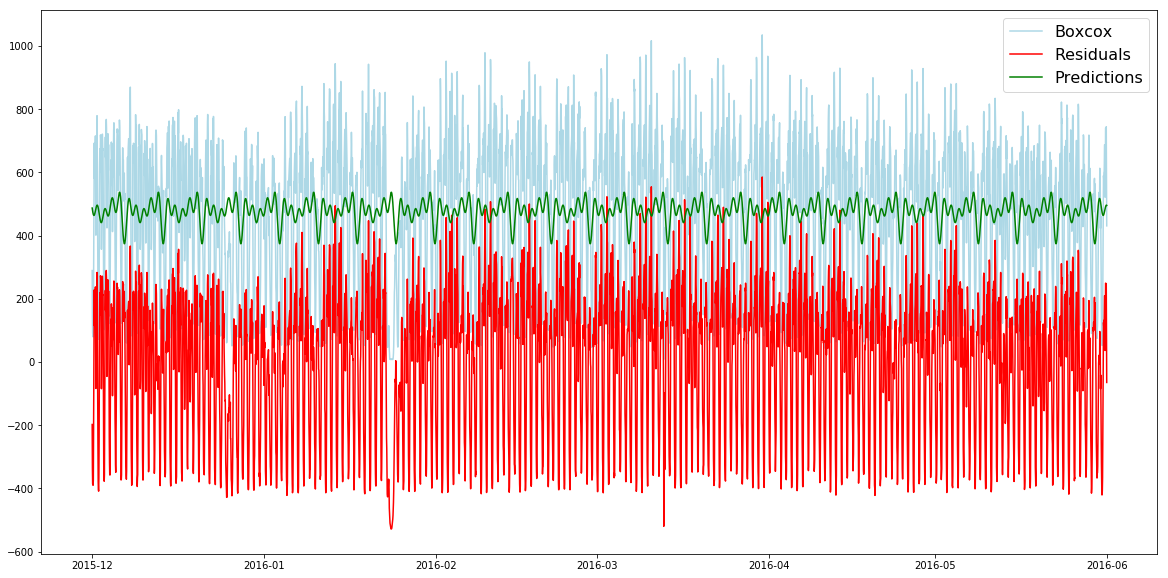

In [10]:
data.index = pd.to_datetime(data.pickup_hour)
data = data.drop(['region', 'pickup_hour'], 1)

lr = LR()
lr.fit(data.iloc[:, 3:], data.boxcox)
predictions = pd.Series(lr.predict(data.iloc[:, 3:]), index=data.index)

plt.figure(figsize=(20,10))
plt.plot(data.boxcox, color ='lightblue', label='Boxcox')
plt.plot(data.boxcox-predictions, label='Residuals', color='red')
plt.plot(predictions, label='Predictions', color='green')
plt.legend(loc=1,prop={'size':16})

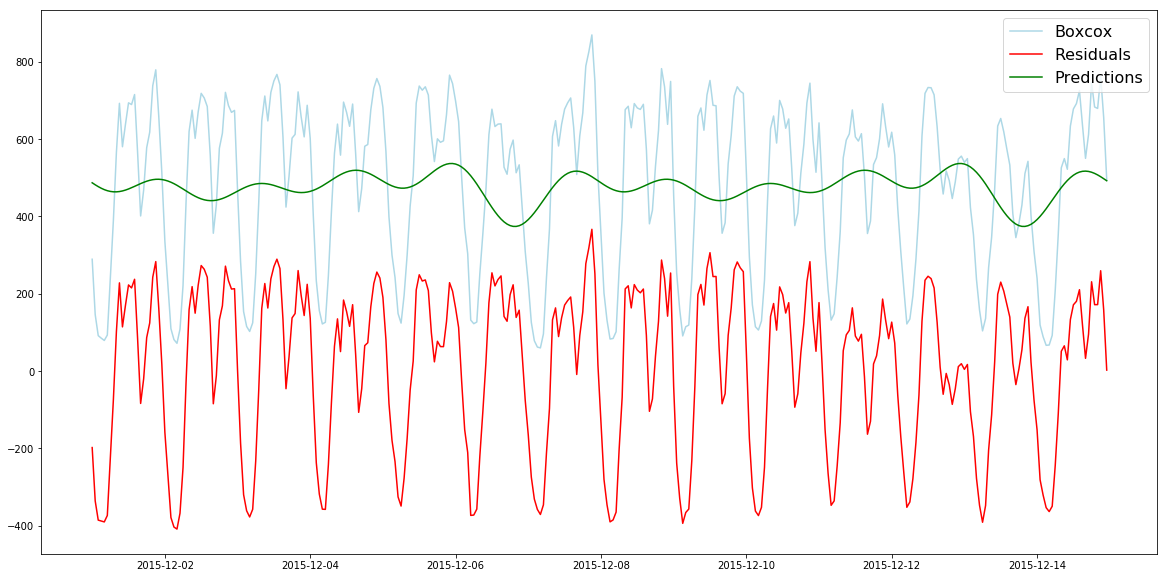

In [11]:
plt.figure(figsize=(20,10))
plt.plot(data.boxcox[:168*2], color ='lightblue', label='Boxcox')
plt.plot((data.boxcox-predictions)[:168*2], label='Residuals', color='red')
plt.plot(predictions[:168*2], label='Predictions', color='green')
plt.legend(loc=1,prop={'size':16})

In [12]:
data.head()

cnt      boxcox   week_s1   week_c1   week_s2   week_c2  \
pickup_hour                                                                    
2015-12-01 00:00:00  394  289.295703  0.000000  1.000000  0.000000  1.000000   
2015-12-01 01:00:00  185  146.036940  0.037391  0.999301  0.074730  0.997204   
2015-12-01 02:00:00  109   91.699744  0.074730  0.997204  0.149042  0.988831   
2015-12-01 03:00:00  100   85.133089  0.111964  0.993712  0.222521  0.974928   
2015-12-01 04:00:00   92   79.266053  0.149042  0.988831  0.294755  0.955573   

                      week_s3   week_c3   week_s4   week_c4   week_s5  \
pickup_hour                                                             
2015-12-01 00:00:00  0.000000  1.000000  0.000000  1.000000  0.000000   
2015-12-01 01:00:00  0.111964  0.993712  0.149042  0.988831  0.185912   
2015-12-01 02:00:00  0.222521  0.974928  0.294755  0.955573  0.365341   
2015-12-01 03:00:00  0.330279  0.943883  0.433884  0.900969  0.532032   
2015-12-01 04:00:00  0.433884  0.900969  0.563320  0.826239  0.680173   

                      week_c5  
pickup_hour                    
2015-12-01 00:00:00  1.000000  
2015-12-01 01:00:00  0.982566  
2015-12-01 02:00:00  0.930874  
2015-12-01 03:00:00  0.846724  
2015-12-01 04:00:00  0.733052

### В начале недели изменения слишком существенные, чтобы моделировать их гармоническими функциями, введём признаки дней недели

In [13]:
data = pd.concat([data, pd.get_dummies(pd.Series(data = data.index, index = data.index).apply(lambda x: x.weekday()), drop_first=True)], axis=1)
data.head()

cnt      boxcox   week_s1   week_c1   week_s2   week_c2  \
pickup_hour                                                                    
2015-12-01 00:00:00  394  289.295703  0.000000  1.000000  0.000000  1.000000   
2015-12-01 01:00:00  185  146.036940  0.037391  0.999301  0.074730  0.997204   
2015-12-01 02:00:00  109   91.699744  0.074730  0.997204  0.149042  0.988831   
2015-12-01 03:00:00  100   85.133089  0.111964  0.993712  0.222521  0.974928   
2015-12-01 04:00:00   92   79.266053  0.149042  0.988831  0.294755  0.955573   

                      week_s3   week_c3   week_s4   week_c4   week_s5  \
pickup_hour                                                             
2015-12-01 00:00:00  0.000000  1.000000  0.000000  1.000000  0.000000   
2015-12-01 01:00:00  0.111964  0.993712  0.149042  0.988831  0.185912   
2015-12-01 02:00:00  0.222521  0.974928  0.294755  0.955573  0.365341   
2015-12-01 03:00:00  0.330279  0.943883  0.433884  0.900969  0.532032   
2015-12-01 04:00:00  0.433884  0.900969  0.563320  0.826239  0.680173   

                      week_c5  1  2  3  4  5  6  
pickup_hour                                      
2015-12-01 00:00:00  1.000000  1  0  0  0  0  0  
2015-12-01 01:00:00  0.982566  1  0  0  0  0  0  
2015-12-01 02:00:00  0.930874  1  0  0  0  0  0  
2015-12-01 03:00:00  0.846724  1  0  0  0  0  0  
2015-12-01 04:00:00  0.733052  1  0  0  0  0  0

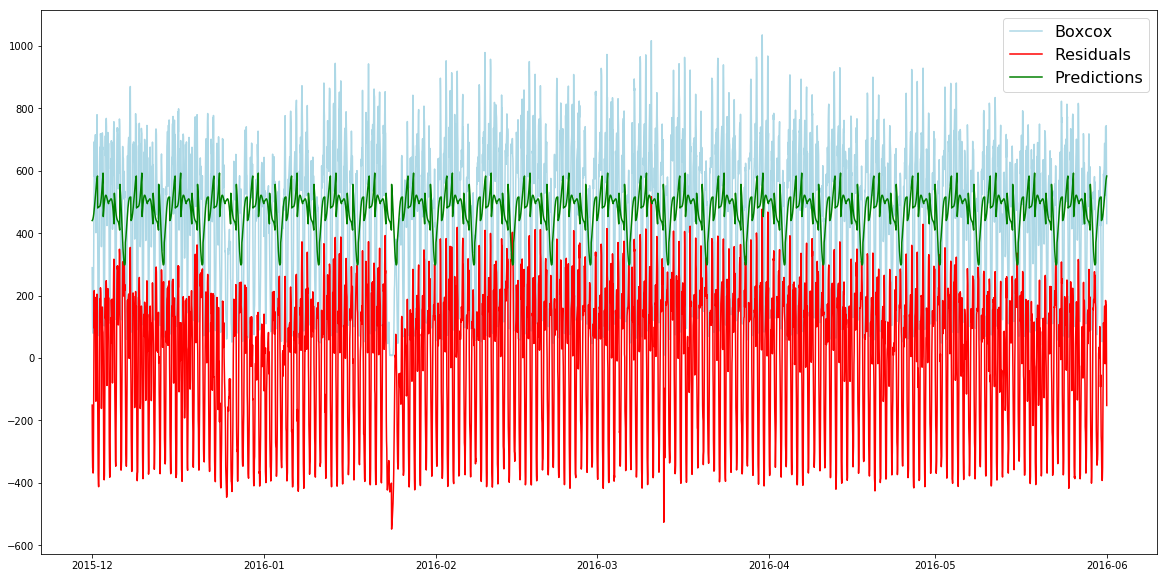

In [14]:
lr = LR()
lr.fit(data.iloc[:, 2:], data.boxcox)
predictions = pd.Series(lr.predict(data.iloc[:, 2:]), index=data.index)

plt.figure(figsize=(20,10))
plt.plot(data.boxcox, color ='lightblue', label='Boxcox')
plt.plot(data.boxcox-predictions, label='Residuals', color='red')
plt.plot(predictions, label='Predictions', color='green')
plt.legend(loc=1,prop={'size':16})

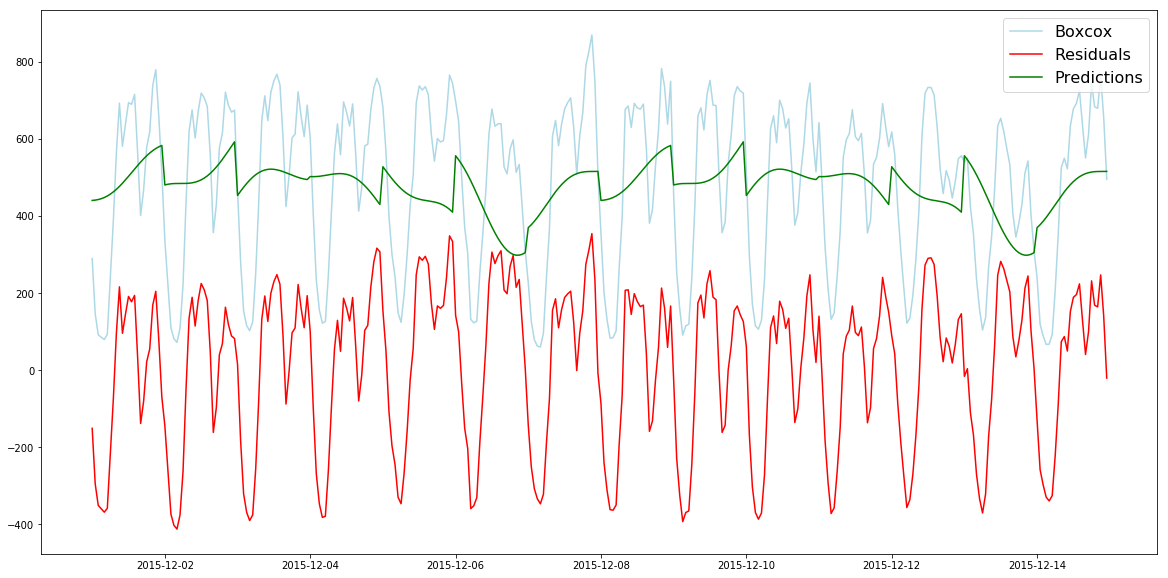

In [15]:
plt.figure(figsize=(20,10))
plt.plot(data.boxcox[:168*2], color ='lightblue', label='Boxcox')
plt.plot((data.boxcox-predictions)[:168*2], label='Residuals', color='red')
plt.plot(predictions[:168*2], label='Predictions', color='green')
plt.legend(loc=1,prop={'size':16})

In [15]:
data.describe()['boxcox']

count    4392.000000
mean      475.761823
std       231.890993
min         8.120274
25%       263.717597
50%       534.899372
75%       654.909920
max      1034.844147
Name: boxcox, dtype: float64

In [11]:
len(data[data.boxcox<50]),len(data[data.boxcox>900])

(31, 39)

### Аномалий не очень много, попробуем добавить для них регрессионные признаки

In [16]:
data['anom_0'] = (data.boxcox<50).apply(int)
data['anom_1'] = (data.boxcox>900).apply(int)

In [17]:
X = data.iloc[:, 2:]
y = data.boxcox
X.head()

week_s1   week_c1   week_s2   week_c2   week_s3  \
pickup_hour                                                             
2015-12-01 00:00:00  0.000000  1.000000  0.000000  1.000000  0.000000   
2015-12-01 01:00:00  0.037391  0.999301  0.074730  0.997204  0.111964   
2015-12-01 02:00:00  0.074730  0.997204  0.149042  0.988831  0.222521   
2015-12-01 03:00:00  0.111964  0.993712  0.222521  0.974928  0.330279   
2015-12-01 04:00:00  0.149042  0.988831  0.294755  0.955573  0.433884   

                      week_c3   week_s4   week_c4   week_s5   week_c5  1  2  \
pickup_hour                                                                   
2015-12-01 00:00:00  1.000000  0.000000  1.000000  0.000000  1.000000  1  0   
2015-12-01 01:00:00  0.993712  0.149042  0.988831  0.185912  0.982566  1  0   
2015-12-01 02:00:00  0.974928  0.294755  0.955573  0.365341  0.930874  1  0   
2015-12-01 03:00:00  0.943883  0.433884  0.900969  0.532032  0.846724  1  0   
2015-12-01 04:00:00  0.900969  0.563320  0.826239  0.680173  0.733052  1  0   

                     3  4  5  6  anom_0  anom_1  
pickup_hour                                      
2015-12-01 00:00:00  0  0  0  0       0       0  
2015-12-01 01:00:00  0  0  0  0       0       0  
2015-12-01 02:00:00  0  0  0  0       0       0  
2015-12-01 03:00:00  0  0  0  0       0       0  
2015-12-01 04:00:00  0  0  0  0       0       0

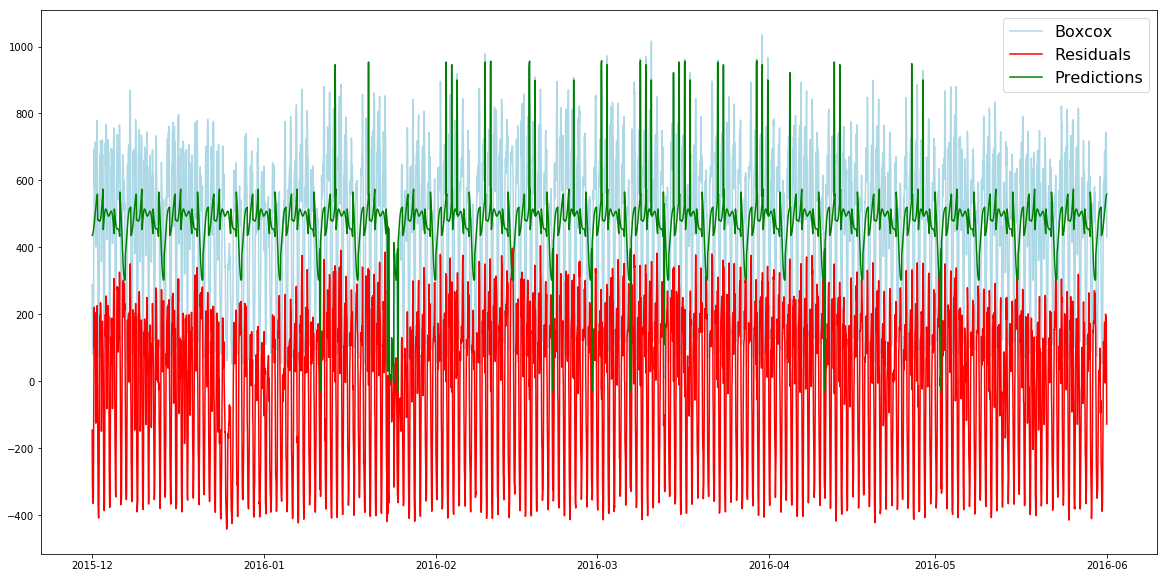

In [19]:
lr.fit(X, y)
predictions = predictions = pd.Series(lr.predict(X), index=X.index)
resid = y-predictions

plt.figure(figsize=(20,10))
plt.plot(y, color ='lightblue', label='Boxcox')
plt.plot(resid, label='Residuals', color='red')
plt.plot(predictions, label='Predictions', color='green')
plt.legend(loc=1,prop={'size':16})

# Выбор порядка дифференцирования

## Без дифференцирования

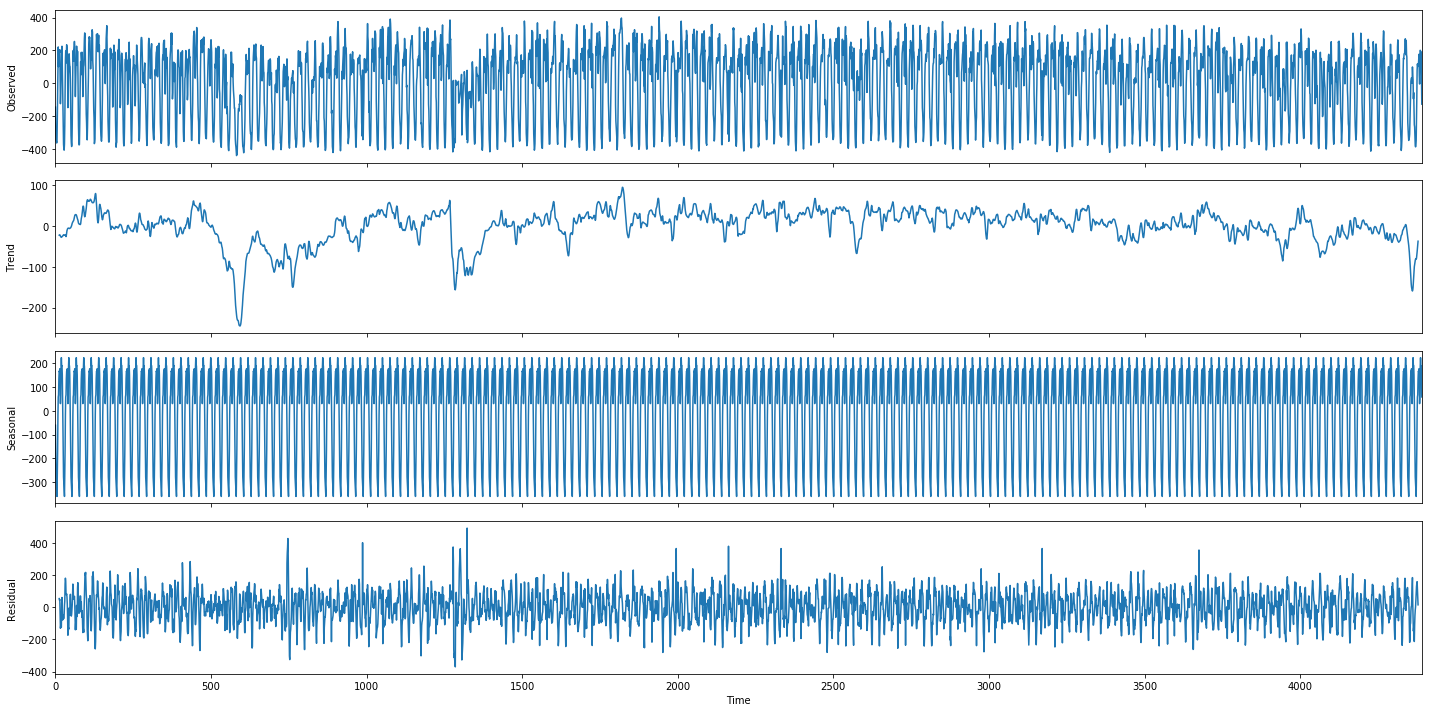

In [17]:
f = sm.tsa.seasonal_decompose(resid.values, freq=24).plot()

## Обычное дифференцирование

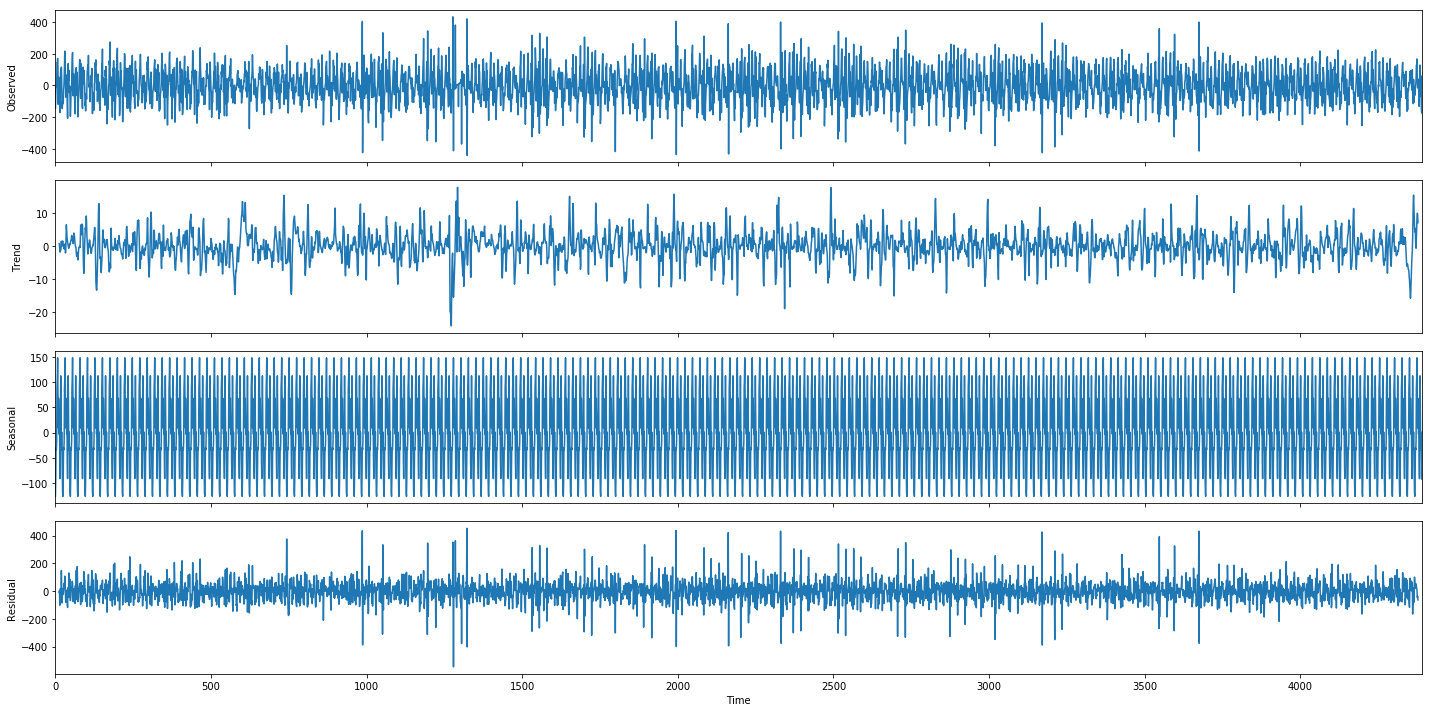

In [23]:
diff1 = (resid - resid.shift(1))[1:]
f = sm.tsa.seasonal_decompose(diff24.values, freq=24).plot()

## Суточное дифференцирование

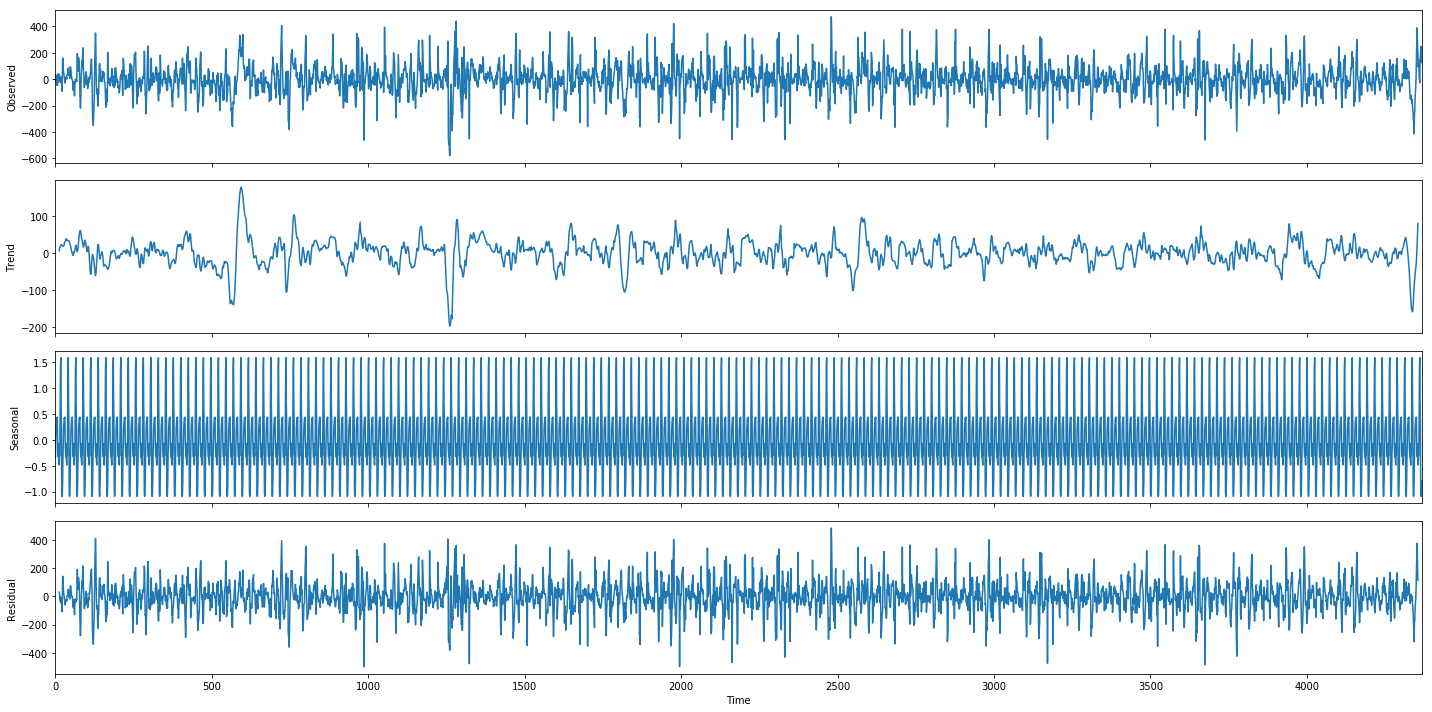

In [18]:
diff24 = (resid - resid.shift(24))[24:]
f = sm.tsa.seasonal_decompose(diff24.values, freq=24).plot()

### Формально проверим гипотезу стационарности, хотя и так было сказано, что критерий Дики-Фуллера в данном случае не информативен

In [19]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(resid)[1])

Критерий Дики-Фуллера: p=0.000000


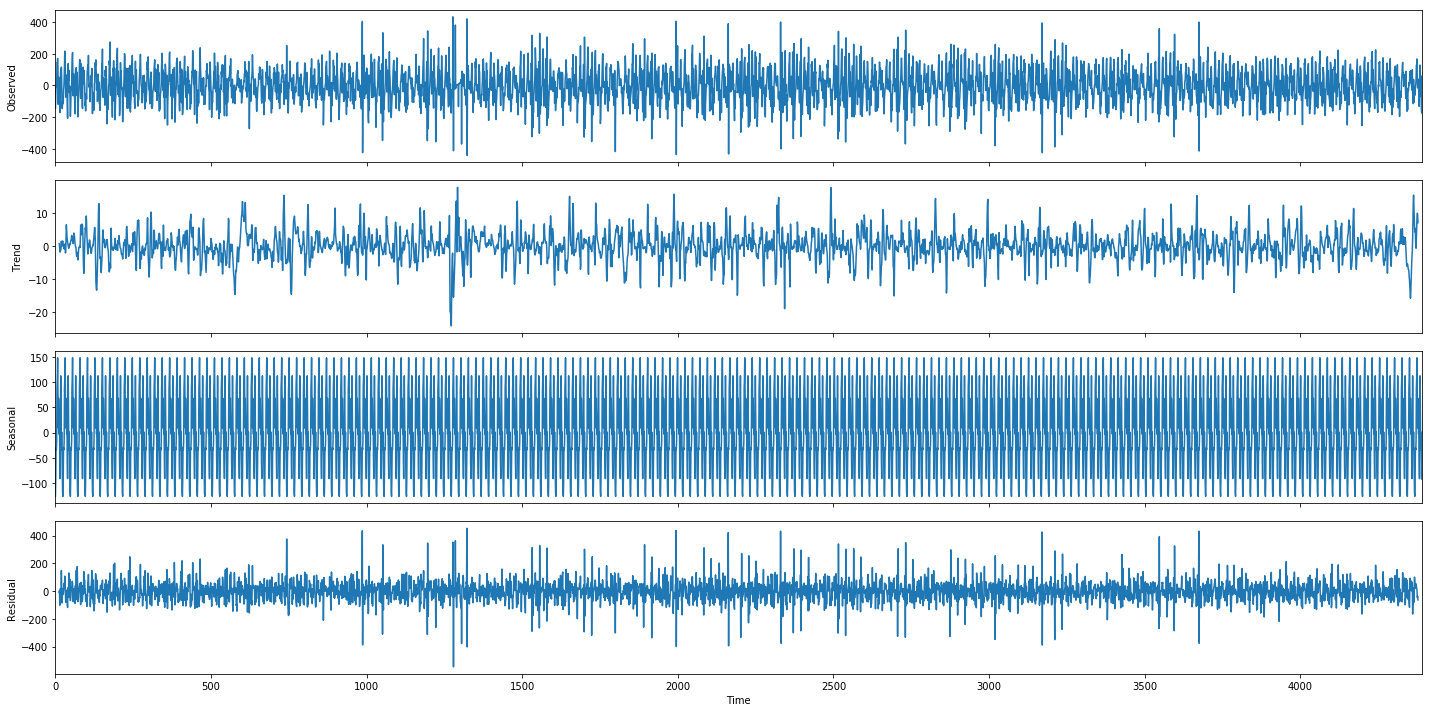

In [20]:
diff24 = (resid - resid.shift(1))[1:]
f = sm.tsa.seasonal_decompose(diff24.values, freq=24).plot()

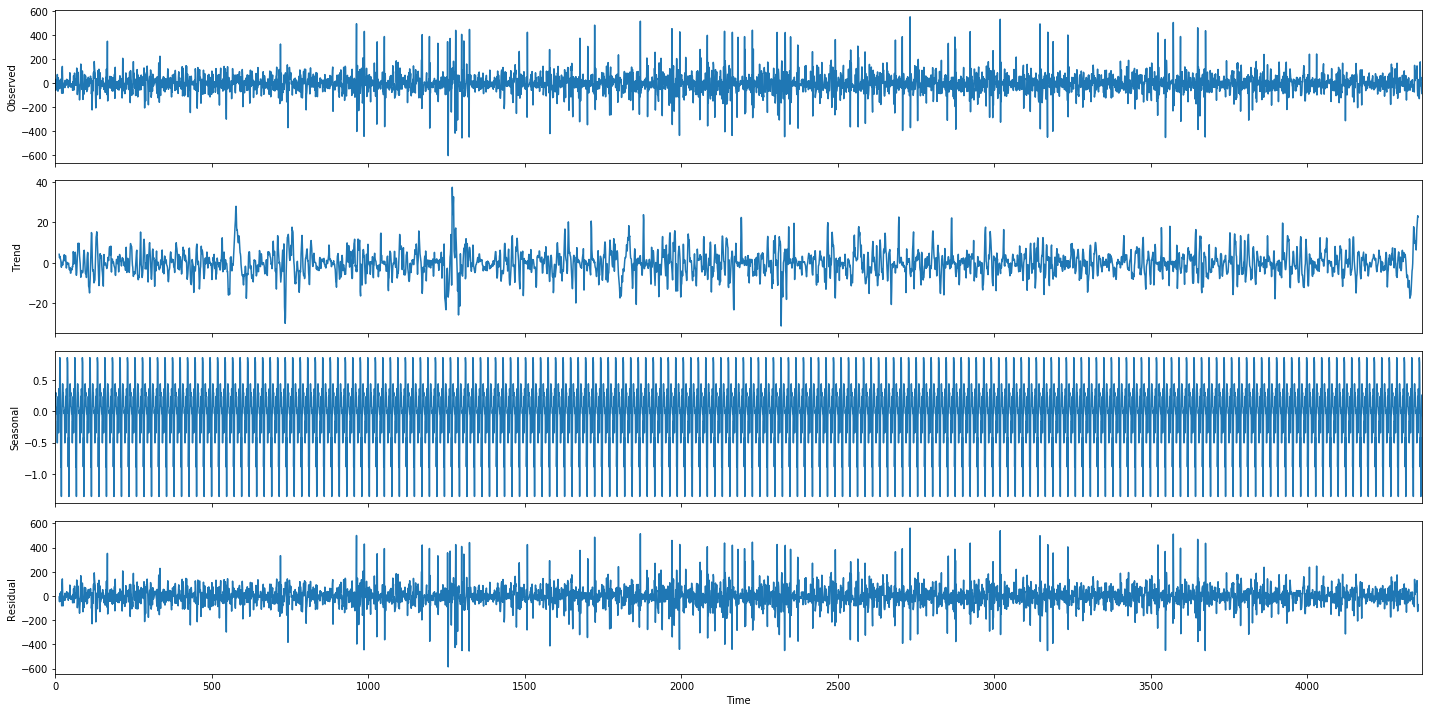

In [24]:
diff_24_1 = (diff1 - diff1.shift(24))[24:]
f = sm.tsa.seasonal_decompose(diff_24_1.values, freq=24).plot()

# Будем строить ACF и PACF для подбора p, P, q, Q

In [21]:
def plot_acf_pacf(data, lags):
    plt.figure(figsize(20,20))
    ax = plt.subplot(211)
    plt1 = sm.graphics.tsa.plot_acf(data.values.squeeze(), lags=lags, ax=ax)
    pylab.show()
    ax = plt.subplot(212)
    plt2 = sm.graphics.tsa.plot_pacf(data.values.squeeze(), lags=lags, ax=ax)
    pylab.show()

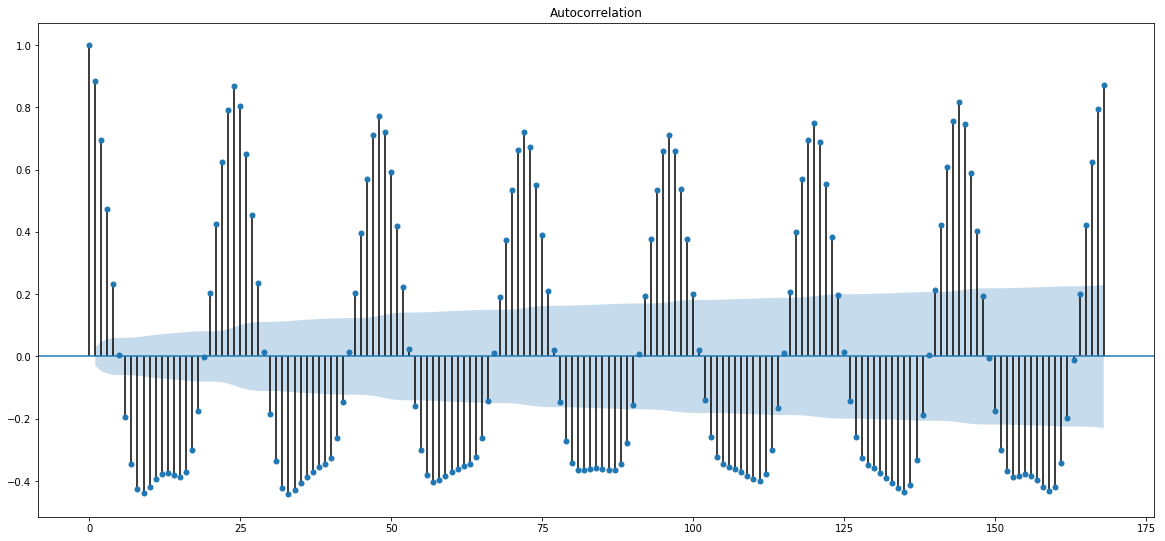

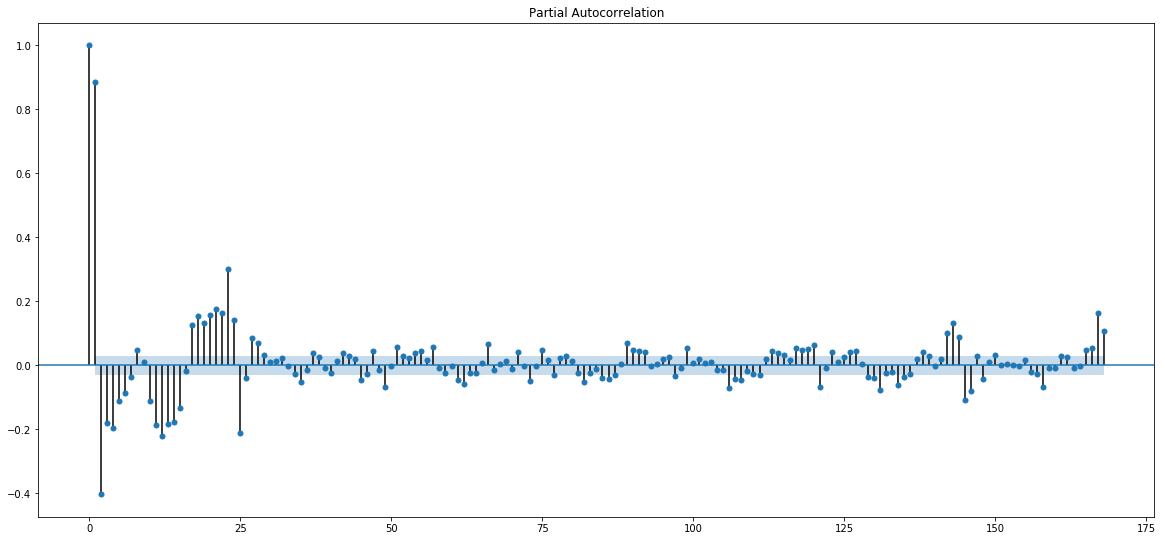

In [40]:
plot_acf_pacf(resid, 168)

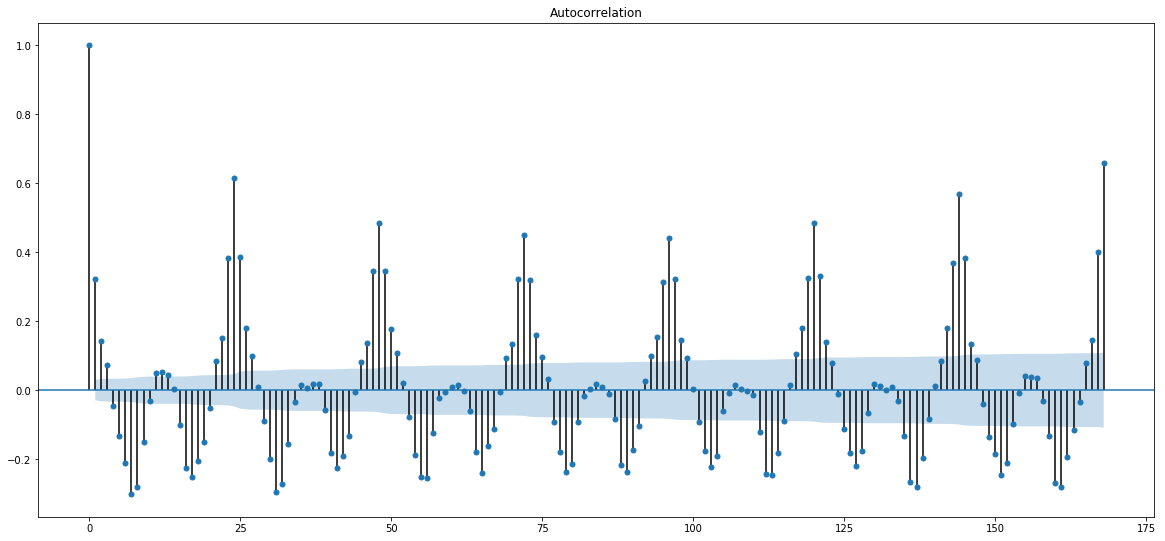

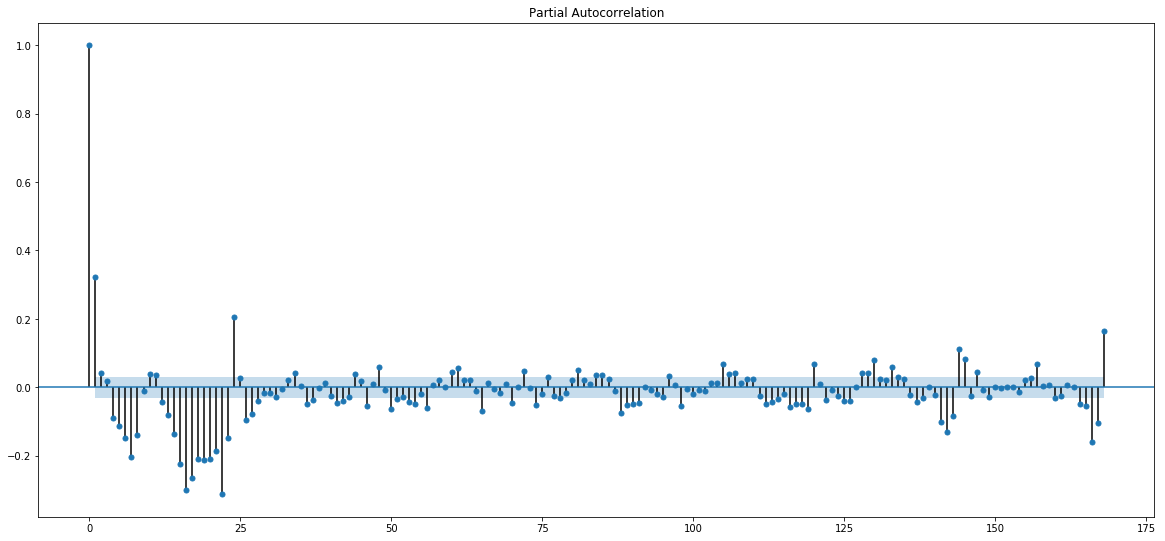

In [27]:
plot_acf_pacf(diff1, 168)

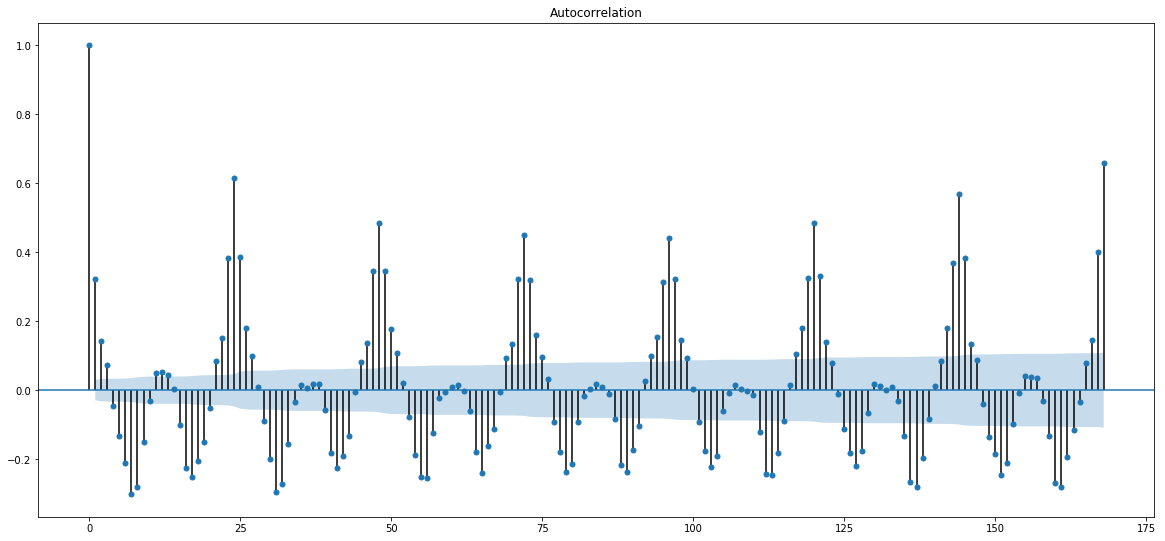

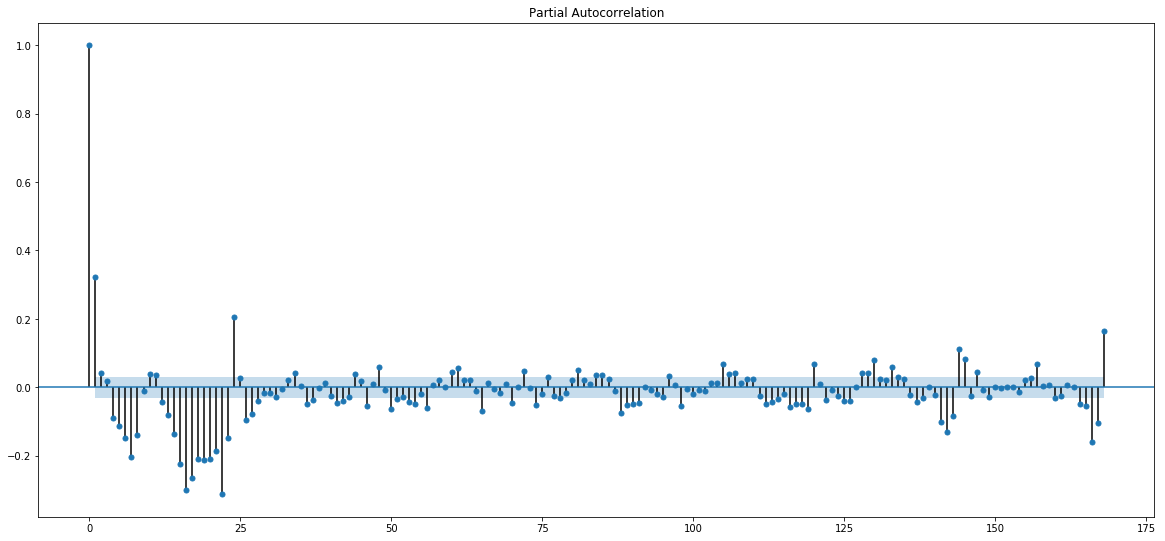

In [28]:
plot_acf_pacf(diff24, 168)

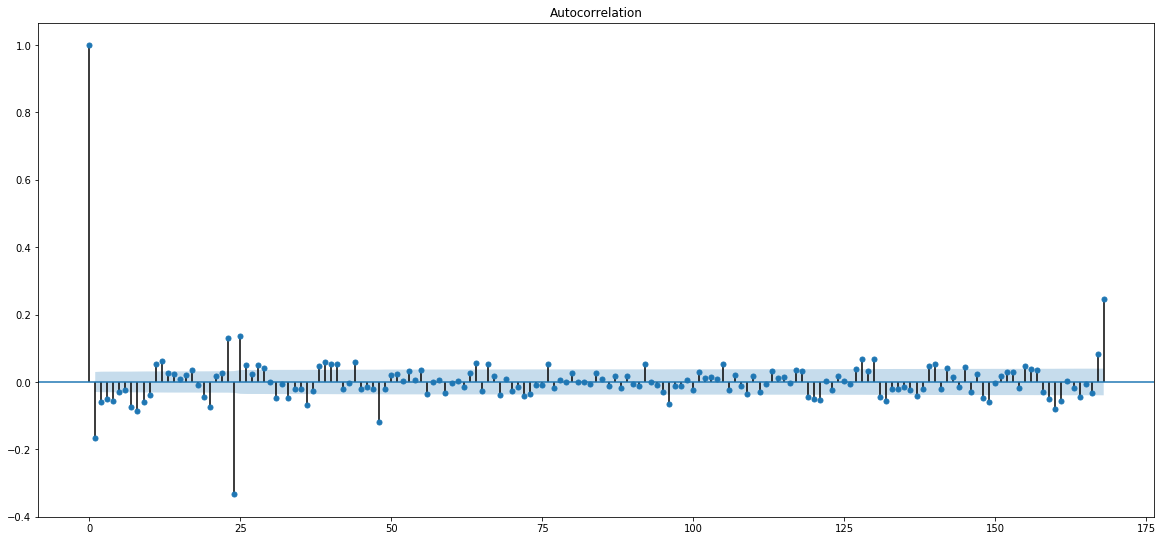

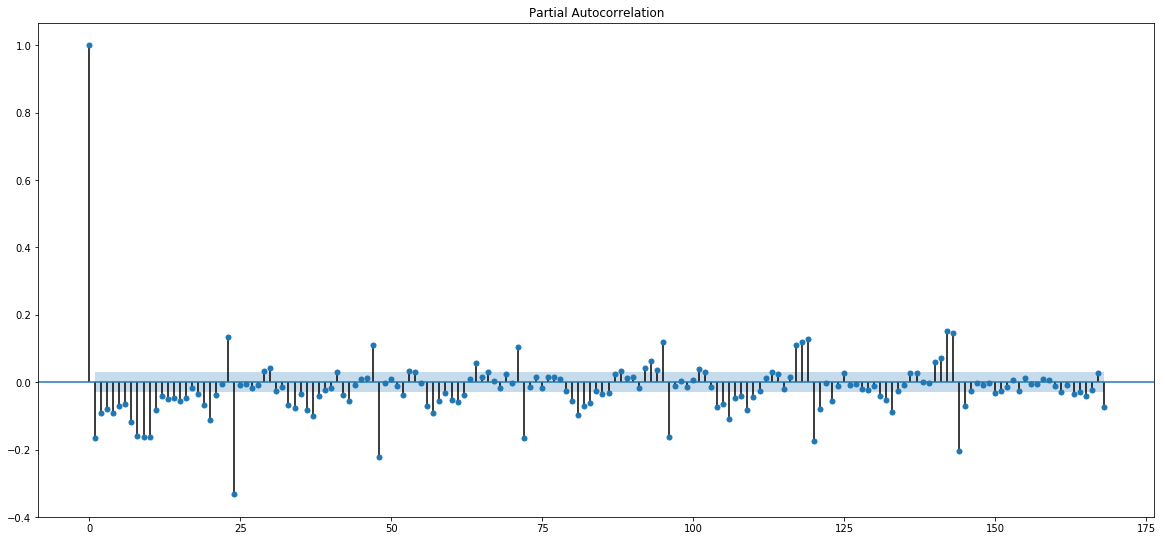

In [237]:
plot_acf_pacf(diff_24_1, 168)

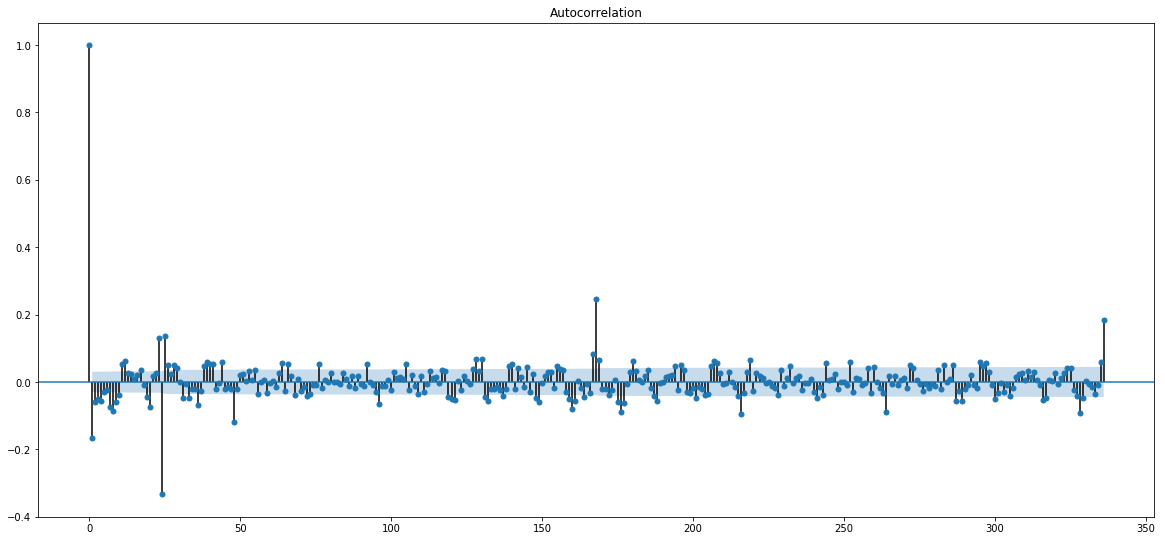

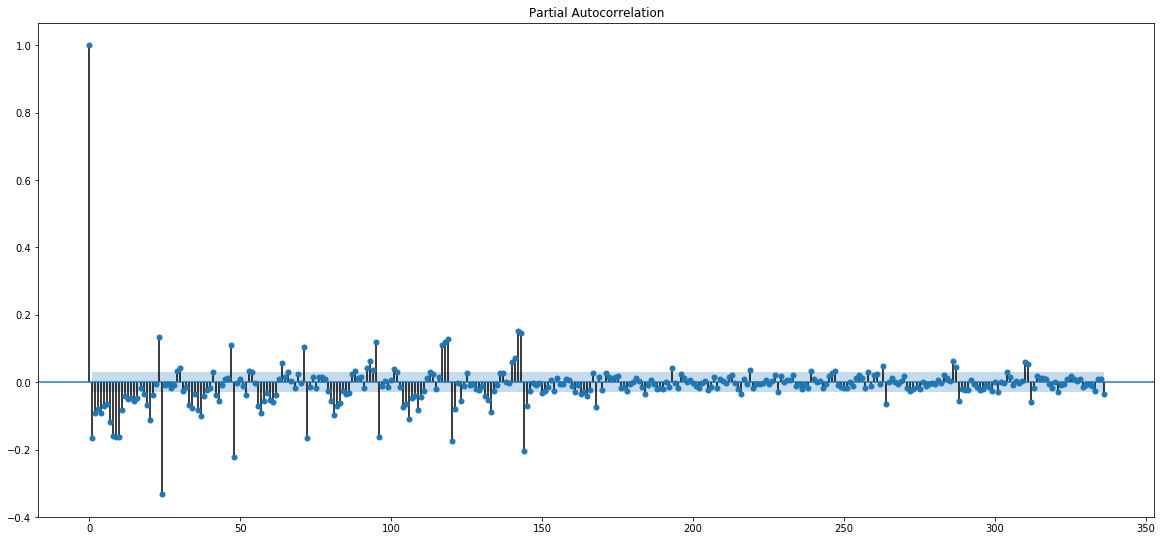

In [240]:
plot_acf_pacf(diff_24_1, 168*2)

## Используя графики, выберем коэффициенты для SARIMAX: D=1, d = 1, Q=0, q=2, P=1, p=5

In [15]:
p=5
d=1
q=2
P=1
D=1
Q=0

ps = range(0, p+1)
qs = range(0, q+1)
Ps = range(0, P+1)
Qs = range(0, Q+1)

parameters_list = list(itertools.product(ps, qs, Ps, Qs))
print("Количество комбинаций параметров: %d" % len(parameters_list))

Количество комбинаций параметров: 36


In [18]:
resid.index = data.pickup_hour

### В целях экономии времени будем считать, что коэффициенты для недельной сезонности и аномалии входят примерно с одинаковыми коэффициентами для всех моделей, и будем использовать SARIMAX на ряде остатков регрессии. Критерий Акаике при этом сдвигается на константу, так что параметры выберем корректные

In [35]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model = sm.tsa.statespace.SARIMAX(resid, 
                                          order=(param[0], d, param[1]), 
                                          seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    print (results[-1])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
[(0, 0, 1, 0), 51339.66437811756]
[(0, 1, 0, 0), 51704.917140174046]
[(0, 1, 1, 0), 51280.76955671022]
[(0, 2, 0, 0), 51655.02348972951]
[(0, 2, 1, 0), 51258.33141507252]
[(1, 0, 0, 0), 51732.634032586415]
[(1, 0, 1, 0), 51288.57390900087]
[(1, 1, 0, 0), 51036.898081100095]
[(1, 1, 1, 0), 50634.622382493784]
[(1, 2, 0, 0), 51077.35893427164]
[(1, 2, 1, 0), 50633.258910785444]
[(2, 0, 0, 0), 51698.33887962373]
[(2, 0, 1, 0), 51274.52188207102]
[(2, 1, 0, 0), 51038.74049979069]
[(2, 1, 1, 0), 50627.61138457174]
[(2, 2, 0, 0), 51040.83017084135]
[(2, 2, 1, 0), 50726.82836495406]
[(3, 0, 0, 0), 51673.05341674004]
[(3, 0, 1, 0), 51260.67324190106]
[(3, 1, 0, 0), 51020.13399038794]
[(3, 1, 1, 0), 50590.10381398334]
[(3, 2, 0, 0), 51076.760266875506]
[(3, 2, 1, 0), 50624.8241111966]
[(4, 0, 0, 0), 51639.71189598522]
[(4, 0, 1, 0), 51222.18350419187]
[(4, 1, 0, 0), 50994.932187948216]
[(4, 1, 1, 0), 50545.827213058416]
[(4, 2, 0, 0), 51034.4250512418]
[(4, 2, 1, 

In [36]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters           aic
32  (5, 1, 1, 0)  50528.089708
26  (4, 1, 1, 0)  50545.827213
20  (3, 1, 1, 0)  50590.103814
22  (3, 2, 1, 0)  50624.824111
14  (2, 1, 1, 0)  50627.611385


In [38]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                             boxcox   No. Observations:                 4392
Model:             SARIMAX(5, 1, 1)x(1, 1, 0, 24)   Log Likelihood              -25256.045
Date:                            Mon, 19 Mar 2018   AIC                          50528.090
Time:                                    15:03:54   BIC                          50579.190
Sample:                                12-01-2015   HQIC                         50546.118
                                     - 05-31-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7096   1294.323      0.001      1.000   -2536.117    2537.536
ar.L2          0.0237    865.057   2.74e-05      1.000   -1695.457    1695.504
ar.L3         -0.0198   1067.977  -1.86e-05      1.000   -2093.215    2093.176
ar.L4         -0.0547   1234.696  -4.43e-05      1.000   -2420.015    2419.906
ar.L5         -0.0672   1270.118  -5.29e-05      1.000   -2489.453    2489.319
ma.L1         -0.9996   1237.793     -0.001      0.999   -2427.029    2425.030
ar.S.L24      -0.3210    642.985     -0.000      1.000   -1260.548    1259.907
sigma2      6157.5928      0.202   3.05e+04      0.000    6157.197    6157.988
===================================================================================
Ljung-Box (Q):                      480.51   Jarque-Bera (JB):              4018.22
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                             0.13
Prob(H) (two-sided):                  0.76   Kurtosis:                         7.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.43e+24. Standard errors may be unstable.
"""

## Строим прогноз. Нужны эндогенные переменные для прогноза, лямбда для обратного Бокса-Кокса.

In [19]:
lmda = shifted_boxcox(data.cnt)[1]
X.head(168).describe()

week_s1       week_c1       week_s2       week_c2       week_s3  \
count  1.680000e+02  1.680000e+02  1.680000e+02  1.680000e+02  1.680000e+02   
mean   9.644236e-17  4.295506e-17  4.353330e-17  9.912706e-18 -2.957290e-17   
std    7.092207e-01  7.092207e-01  7.092207e-01  7.092207e-01  7.092207e-01   
min   -1.000000e+00 -1.000000e+00 -1.000000e+00 -1.000000e+00 -1.000000e+00   
25%   -7.071068e-01 -7.071068e-01 -6.933925e-01 -6.933925e-01 -7.071068e-01   
50%    6.123234e-17 -6.123234e-17  6.123234e-17 -3.061617e-16  6.123234e-17   
75%    7.071068e-01  7.071068e-01  6.933925e-01  6.933925e-01  7.071068e-01   
max    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

            week_c3       week_s4       week_c4       week_s5       week_c5  \
count  1.680000e+02  1.680000e+02  1.680000e+02  1.680000e+02  1.680000e+02   
mean  -4.625929e-17 -4.774620e-17  1.718202e-17 -3.172066e-17  8.921435e-17   
std    7.092207e-01  7.092207e-01  7.092207e-01  7.092207e-01  7.092207e-01   
min   -1.000000e+00 -9.972038e-01 -1.000000e+00 -1.000000e+00 -1.000000e+00   
25%   -7.071068e-01 -6.801727e-01 -7.330519e-01 -7.071068e-01 -7.071068e-01   
50%   -6.123234e-17 -1.224647e-16  6.245005e-17 -5.820167e-16  1.379275e-16   
75%    7.071068e-01  6.801727e-01  7.330519e-01  7.071068e-01  7.071068e-01   
max    1.000000e+00  9.972038e-01  1.000000e+00  1.000000e+00  1.000000e+00   

                1           2           3           4           5           6  \
count  168.000000  168.000000  168.000000  168.000000  168.000000  168.000000   
mean     0.142857    0.142857    0.142857    0.142857    0.142857    0.142857   
std      0.350973    0.350973    0.350973    0.350973    0.350973    0.350973   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

       anom_0  anom_1  
count   168.0   168.0  
mean      0.0     0.0  
std       0.0     0.0  
min       0.0     0.0  
25%       0.0     0.0  
50%       0.0     0.0  
75%       0.0     0.0  
max       0.0     0.0

### Тут нет аномалий, так что первых 168 признаков недельной сезонности хватит для эндогенных признаков предсказываемого периода (июнь 2016)

In [18]:
forecast_datetimes = 720
date_list = [data.index[-1] + relativedelta(hours=x) for x in range(1,forecast_datetimes+1)]
hours_shift = (datetime.datetime.strptime("2016-06-01", "%Y-%m-%d").weekday()-X.index[0].weekday()) * 24 #сдвиг дня недели
future = pd.concat([data.head(168)] * (int(forecast_datetimes/168) + 2))[hours_shift:hours_shift+forecast_datetimes]
future.index = date_list
data_ = pd.concat([data, future])
X_future = pd.concat([X.head(168)] * (int(forecast_datetimes/168) + 2))[hours_shift:hours_shift+forecast_datetimes]
lr_pred = lr.predict(X_future)
sarimax_boxcox = pd.Series(data = lr_pred, index=date_list)+best_model.predict(start=data.shape[0], end=data_.shape[0]-1)
sarimax_cnt = inverse_shifted_boxcox(sarimax_boxcox, lmda=lmda)
data_.cnt = data.cnt.values.tolist() + sarimax_cnt.values.tolist()
data_.boxcox = data.boxcox.values.tolist() + sarimax_boxcox.values.tolist()

# Грузим июньские данные и смотрим, как получится их спрогнозировать

In [28]:
test_data = data_for_time_interval_and_region(2016, 6, 2016, 6)
test_y = test_data.cnt
test_y.index = pd.to_datetime(test_data.pickup_hour)

/home/feshch/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


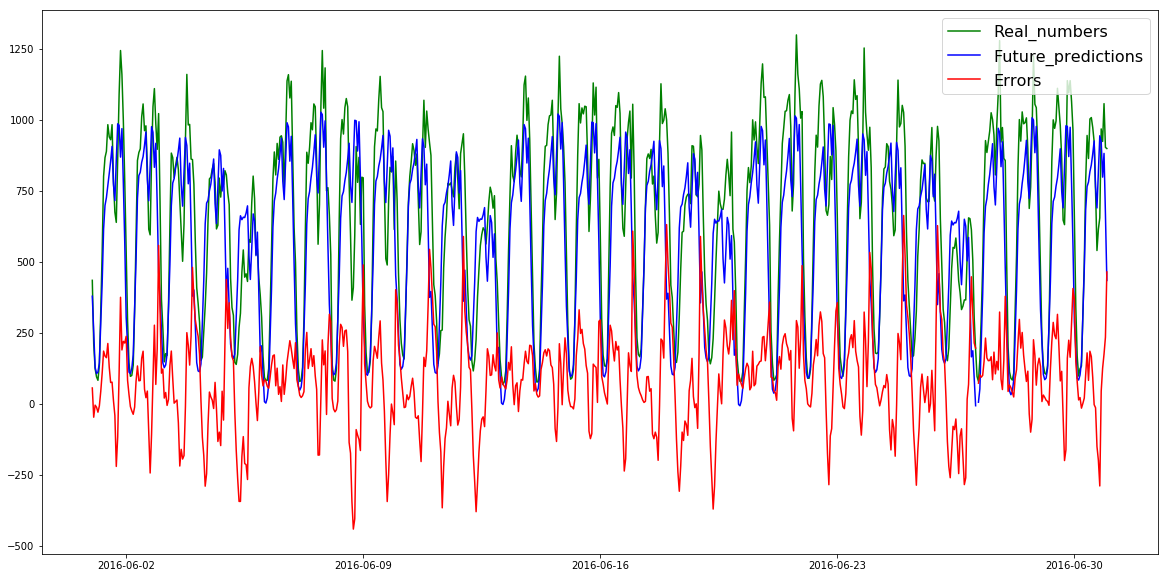

In [15]:
plt.figure(figsize(20,10))
plt.plot(test_y, label='Real_numbers', color='green')
plt.plot(data_.tail(forecast_datetimes).cnt, color ='blue', label='Future_predictions')
plt.plot(test_y-data_.tail(forecast_datetimes).cnt, label='Errors', color='red')
plt.legend(loc=1,prop={'size':16})

### По мере удаления от дат, на которых модель обучается, естественно, происходит падение качества предсказаний. Визуально присутствует недельная сезонность, но для полного избавления от неё придётся делать по K=168 синусов и косинусов, что существенно поднимет затрачиваемую память и время обучения, а для сравнения по AIC его и так требуется достаточно много. Кроме того, ЛЮБОЙ метод создания признаков для ПОЛНОГО избавления от недельной сезонности неизбежно учтёт ещё и суточную сезонность, поскольку в неделе РОВНО 7 суток, так что SARIMAX не понадобится для дневной сезонности, а смысл задания был в том, чтобы для меньшей сезонности использовать SARIMAX. 

## Из-за вычислительной сложности один раз попробую радикально улучшить качество модели без перебора всех параметров, пользуясь тем, что прослеживается тенденция роста критерия Акаике при увеличении количества авторегрессионных признаков и признаков скользящего среднего. Имеет смысл сделать регрессию одновременно с новыми признаками и авторегрессию, подавая как exog в SARIMAX, и поднять p, q, P и Q.

In [20]:
K=15
p = 2.*pi/168.
for i in range(1, K+1):
    phi = p*i
    data['week_s'+str(i)] = sin(np.array(list(range(0, len(data))))*phi)
    data['week_c'+str(i)] = cos(np.array(list(range(0, len(data))))*phi)
X = data.iloc[:, 2:]
data.head()

cnt      boxcox   week_s1   week_c1   week_s2   week_c2  \
pickup_hour                                                                    
2015-12-01 00:00:00  394  289.295703  0.000000  1.000000  0.000000  1.000000   
2015-12-01 01:00:00  185  146.036940  0.037391  0.999301  0.074730  0.997204   
2015-12-01 02:00:00  109   91.699744  0.074730  0.997204  0.149042  0.988831   
2015-12-01 03:00:00  100   85.133089  0.111964  0.993712  0.222521  0.974928   
2015-12-01 04:00:00   92   79.266053  0.149042  0.988831  0.294755  0.955573   

                      week_s3   week_c3   week_s4   week_c4    ...     \
pickup_hour                                                    ...      
2015-12-01 00:00:00  0.000000  1.000000  0.000000  1.000000    ...      
2015-12-01 01:00:00  0.111964  0.993712  0.149042  0.988831    ...      
2015-12-01 02:00:00  0.222521  0.974928  0.294755  0.955573    ...      
2015-12-01 03:00:00  0.330279  0.943883  0.433884  0.900969    ...      
2015-12-01 04:00:00  0.433884  0.900969  0.563320  0.826239    ...      

                     week_s11  week_c11  week_s12  week_c12  week_s13  \
pickup_hour                                                             
2015-12-01 00:00:00  0.000000  1.000000  0.000000  1.000000  0.000000   
2015-12-01 01:00:00  0.399892  0.916562  0.433884  0.900969  0.467269   
2015-12-01 02:00:00  0.733052  0.680173  0.781831  0.623490  0.826239   
2015-12-01 03:00:00  0.943883  0.330279  0.974928  0.222521  0.993712   
2015-12-01 04:00:00  0.997204 -0.074730  0.974928 -0.222521  0.930874   

                     week_c13  week_s14      week_c14  week_s15  week_c15  
pickup_hour                                                                
2015-12-01 00:00:00  1.000000  0.000000  1.000000e+00  0.000000  1.000000  
2015-12-01 01:00:00  0.884115  0.500000  8.660254e-01  0.532032  0.846724  
2015-12-01 02:00:00  0.563320  0.866025  5.000000e-01  0.900969  0.433884  
2015-12-01 03:00:00  0.111964  1.000000 -1.608123e-16  0.993712 -0.111964  
2015-12-01 04:00:00 -0.365341  0.866025 -5.000000e-01  0.781831 -0.623490  

[5 rows x 40 columns]

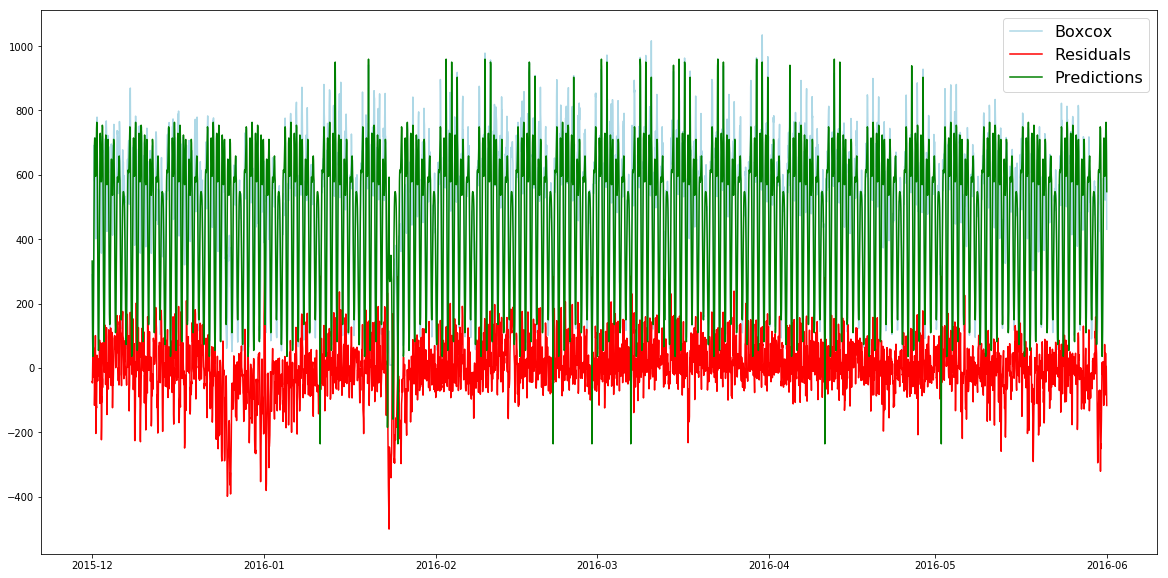

In [21]:
lr.fit(X, y)
predictions = predictions = pd.Series(lr.predict(X), index=X.index)
resid = y-predictions

plt.figure(figsize=(20,10))
plt.plot(y, color ='lightblue', label='Boxcox')
plt.plot(resid, label='Residuals', color='red')
plt.plot(predictions, label='Predictions', color='green')
plt.legend(loc=1,prop={'size':16})

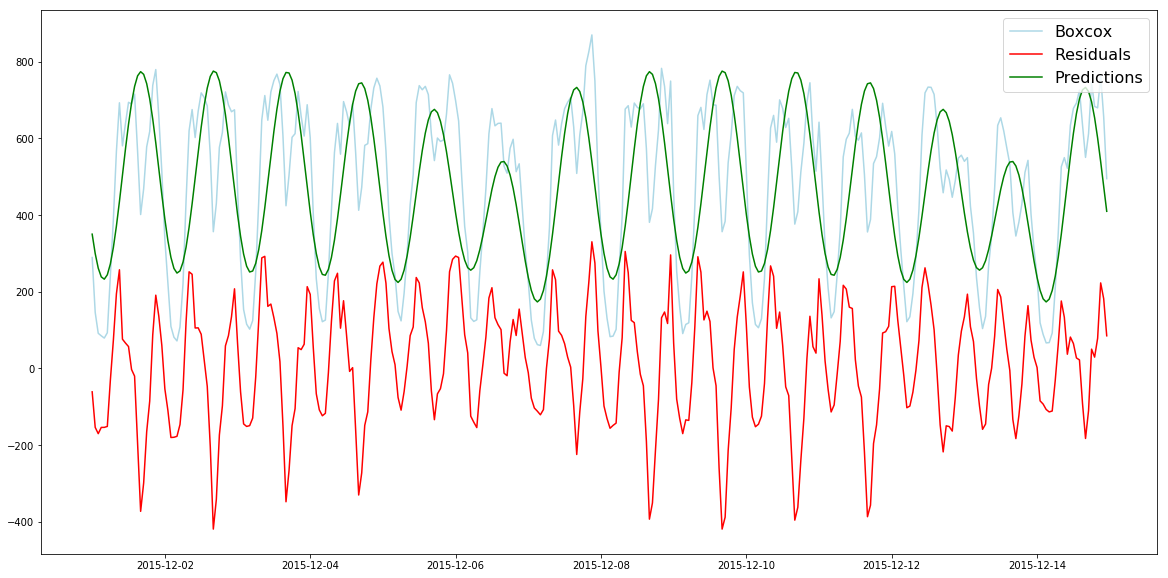

In [41]:
plt.figure(figsize=(20,10))
plt.plot(y[:168*2], color ='lightblue', label='Boxcox')
plt.plot(resid[:168*2], label='Residuals', color='red')
plt.plot(predictions[:168*2], label='Predictions', color='green')
plt.legend(loc=1,prop={'size':16})

### Новые признаки явно помогают, хотя, как уже было сказано, ситуация далека от идеальной, когда K сильно недотягивает до 168

In [31]:
parameters_list = [(5, 1, 1, 0)]
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model = sm.tsa.statespace.SARIMAX(endog=resid,
                                          order=(param[0], 1, param[1]), 
                                          seasonal_order=(param[2], 1, param[3], 24)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    print (results[-1])

[(5, 1, 1, 0), 48078.96332692291]


In [26]:
warnings.filterwarnings('default')
forecast_datetimes = 720
date_list = [data.index[-1] + relativedelta(hours=x) for x in range(1,forecast_datetimes+1)]
hours_shift = (datetime.datetime.strptime("2016-06-01", "%Y-%m-%d").weekday()-X.index[0].weekday()) * 24 #сдвиг дня недели
future = pd.concat([data.head(168)] * (int(forecast_datetimes/168) + 2))[hours_shift:hours_shift+forecast_datetimes]
future.index = date_list
data_ = pd.concat([data, future])
X_future = pd.concat([X.head(168)] * (int(forecast_datetimes/168) + 2))[hours_shift:hours_shift+forecast_datetimes]
lr_pred = lr.predict(X_future)
sarimax_boxcox = pd.Series(data = lr_pred, index=date_list)+best_model.predict(start=data.shape[0], end=data_.shape[0]-1)
sarimax_cnt = inverse_shifted_boxcox(sarimax_boxcox, lmda=lmda)
data_.cnt = data.cnt.values.tolist() + sarimax_cnt.values.tolist()
data_.boxcox = data.boxcox.values.tolist() + sarimax_boxcox.values.tolist()

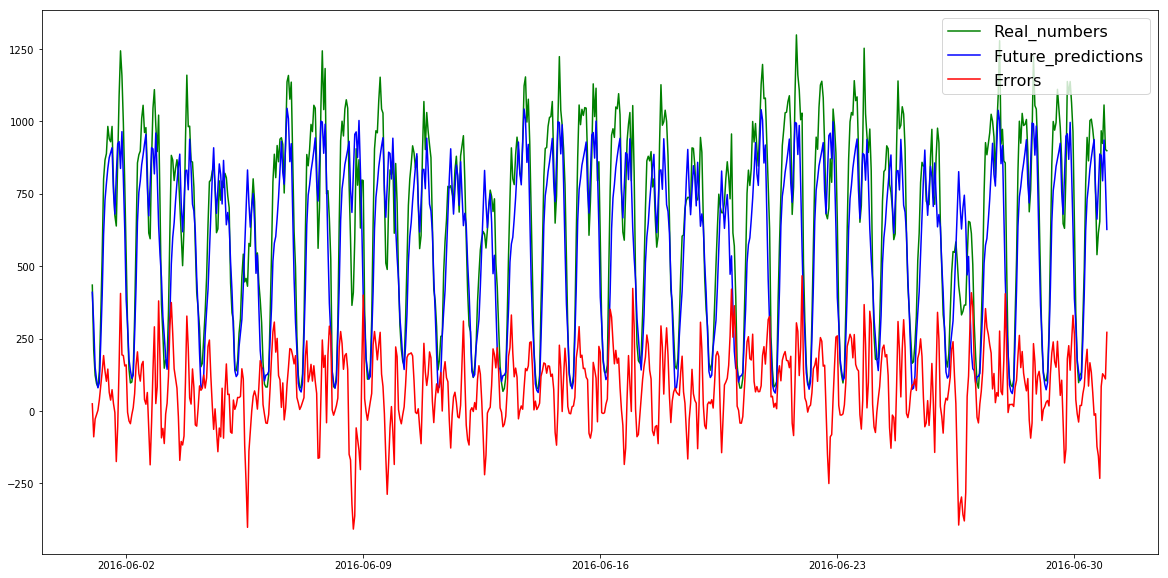

In [29]:
plt.figure(figsize(20,10))
plt.plot(test_y, label='Real_numbers', color='green')
plt.plot(data_.tail(forecast_datetimes).cnt, color ='blue', label='Future_predictions')
plt.plot(test_y-data_.tail(forecast_datetimes).cnt, label='Errors', color='red')
plt.legend(loc=1,prop={'size':16})

In [30]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 4392
Model:             SARIMAX(5, 1, 1)x(1, 1, 0, 24)   Log Likelihood              -24031.482
Date:                            Tue, 20 Mar 2018   AIC                          48078.963
Time:                                    20:11:51   BIC                          48130.064
Sample:                                12-01-2015   HQIC                         48096.991
                                     - 05-31-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7279   8980.534    8.1e-05      1.000   -1.76e+04    1.76e+04
ar.L2         -0.1202   3378.327  -3.56e-05      1.000   -6621.519    6621.279
ar.L3          0.0252   4605.059   5.48e-06      1.000   -9025.724    9025.774
ar.L4         -0.0555   3489.291  -1.59e-05      1.000   -6838.940    6838.829
ar.L5          0.0952   4041.352   2.36e-05      1.000   -7920.810    7921.000
ma.L1         -1.0000   7469.332     -0.000      1.000   -1.46e+04    1.46e+04
ar.S.L24      -0.3850   2034.646     -0.000      1.000   -3988.218    3987.448
sigma2      3517.3224      2.124   1655.916      0.000    3513.159    3521.486
===================================================================================
Ljung-Box (Q):                      273.84   Jarque-Bera (JB):              1208.95
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                            -0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.97e+23. Standard errors may be unstable.
"""

## Модель всё ещё далека от идеальной, но новые признаки заметно улучшили её.

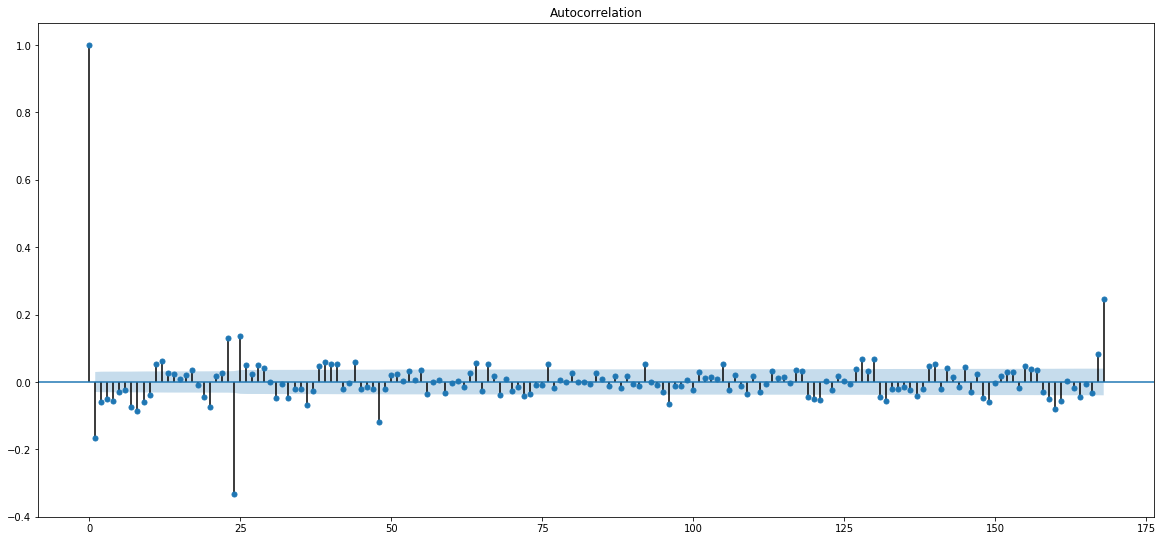

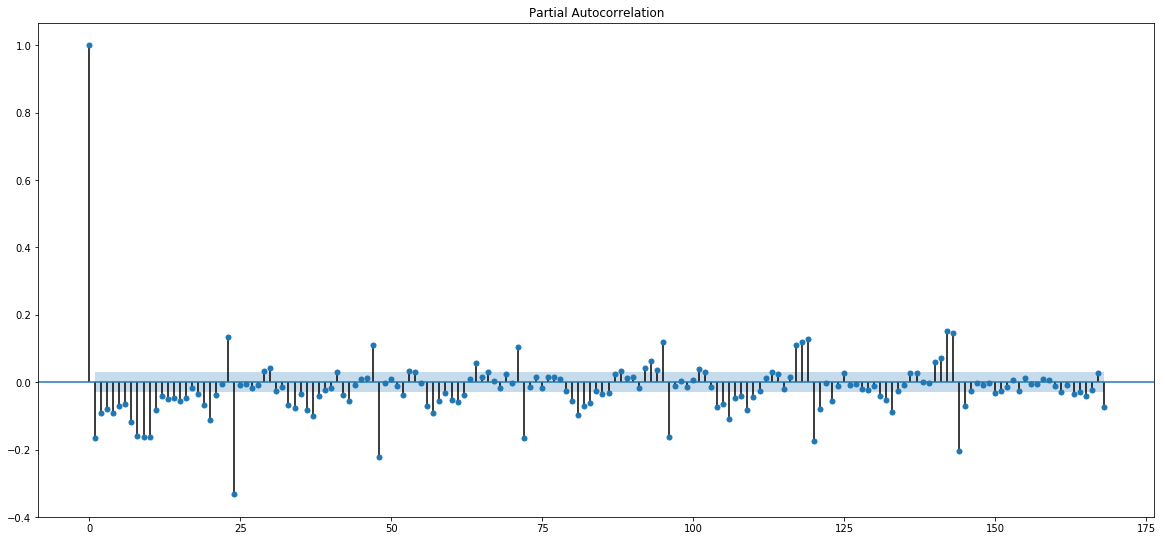

In [23]:
diff1 = (resid - resid.shift(1))[1:]
diff_24_1 = (diff1 - diff1.shift(24))[24:]
plot_acf_pacf(diff_24_1, 168)